- 합성곱으로 압축된 정보를 업셈플링을 이용해 복원
- 정보를 압축(인코더)-복원(디코더) 인코더-디코더
- U-Net : 인코더 디코더를 사용한 모델
 - 인코더의 출력과 디코더의 출력을 합쳐서 다음층의 입력으로 사용

CAE : Convolution Auto Encoder

- 이미지 노이즈 제거
- 노이즈 : 데이터에 섞여 정보를 왜곡하는 정보
- 가우시안 노이즈 : 노이즈의 형태가 정규분포를 따르는 것
- 이미지에 노이즈
 - 초점이 맞지 않아서 생기는 블러링, 이미지 일부가 결손, 전송하는 과정에서 생기는 노이즈 등등.
 - 센서오차,, 등

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [3]:
def gaussian_noise(x , scale=0.8):
  # 가우스 노이즈 추가
  # loc : 잡음의평균 위치 즉 평균은 0,  scale : 표준편차
  gaussian_data = x + np.random.normal(loc=0,scale=scale, size = x.shape)
  # 픽셀을 0과 1사이로 정규화
  gaussian_data = np.clip(gaussian_data,0,1)
  gaussian_data = torch.tensor(gaussian_data)
  gaussian_data =   gaussian_data.type(torch.FloatTensor)
  return gaussian_data

In [4]:
# 데이터
train_data = MNIST(root="./", train=True, download=True,transform=ToTensor())
test_data = MNIST(root="./", train=False, download=True,transform=ToTensor())
# 첫번째 원본데이터
img =  train_data.data[0]
# 노이즈 추가
gaussian =  gaussian_noise(img)

100%|██████████| 9912422/9912422 [00:00<00:00, 158661092.14it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 10481586.38it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34887513.73it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21073593.77it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




<ipython-input-3-5fbf7793fd94>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data = torch.tensor(gaussian_data)


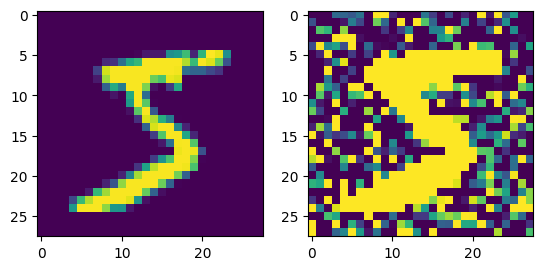

In [5]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(gaussian)
plt.show()

In [6]:
# 학습용 데이터 셋
from torch.utils.data.dataset import Dataset

In [7]:
class CAEDataset(Dataset):
  def __init__(self):
    self.mnist = MNIST(root="./", train=True, download=True,transform=ToTensor())
    self.data = []  #노이즈가 섞인 데이터를 담는 리스트

    # 노이즈 추가하기
    for i in range(len(self.mnist)):
      noisy_input =  gaussian_noise(self.mnist.data[i])  # 텐서모양이 되어야 함
      input_tensor = torch.tensor(noisy_input)
      self.data.append(torch.unsqueeze(input_tensor, dim=0))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    data = self.data[index]
    # 원본이미지도 0과 1사이로 값을 맞춰줌
    label = self.mnist.data[index]/255
    return data,label

In [8]:
import torch
import torch.nn as nn

In [9]:
# 베이직 블럭

class BasicBlock(nn.Module):
  def __init__(self,input,output,hidden) -> None:
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(input,hidden,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(hidden,output,kernel_size=3,padding=1)
    self.relu = nn.ReLU()
  def forward(self,x):
    x =self.relu(self.conv1(x))
    x =self.relu(self.conv2(x))
    return x

In [10]:
# 인코더 모델
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    # mnist가 입력체널이 1개
    self.conv1 = BasicBlock(1,16,16) # input, output, hidden
    self.conv2 = BasicBlock(16,8,8)
    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
  def forward(self,x):
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    return x

In [11]:
# 디코더 모델
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    # mnist가 입력체널이 1개
    self.conv1 = BasicBlock(8,8,8) # input, output, hidden
    self.conv2 = BasicBlock(8,16,16)
    # 출력층은 합성곱층
    self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

    # 업셈플링
    self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2, stride=2)
    self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2, stride=2)

  # 폴링대신에 입력을 키우는 업셈플링을 사용
  def forward(self,x):
    x = self.upsample1(self.conv1(x))
    x = self.upsample2(self.conv2(x))
    x = self.conv3(x)
    return x

In [12]:
# 디코더 모델
class CAE(nn.Module):
  def __init__(self):
    super(CAE, self).__init__()
    self.enc = Encoder()
    self.dec = Decoder()

  # 폴링대신에 입력을 키우는 업셈플링을 사용
  def forward(self,x):
    x = self.dec(self.enc(x))
    x = torch.squeeze(x) # dim=0  채널 차원을 삭제
    return x

In [13]:
from torch.optim.adam import Adam

In [14]:
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
# 학습
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainset = CAEDataset()
train_loader = DataLoader(trainset,batch_size=32)

model = CAE().to(device)
optim = Adam(model.parameters(),lr=1e-3)

for epoch in range(10):
  iter = tqdm(train_loader)
  for data, label in iter:
    optim.zero_grad()
    pred = model(data.to(device))  # 채널정보를 가지고 있음 제거해야 함
    pred = torch.squeeze(pred)
    loss = nn.MSELoss()(pred,label.to(device))
    loss.backward()
    optim.step()
    iter.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(), 'CAE.pth')

<ipython-input-3-5fbf7793fd94>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data = torch.tensor(gaussian_data)
<ipython-input-7-2fc6908b538d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch:9 loss:0.00841857586055994: 100%|██████████| 1875/1875 [00:13<00:00, 136.43it/s]


<ipython-input-3-5fbf7793fd94>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data = torch.tensor(gaussian_data)


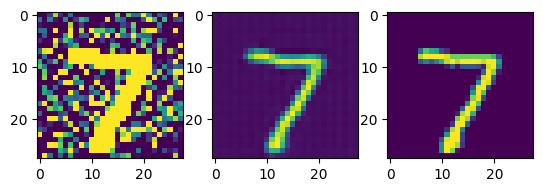

In [15]:
# 평가
# 모델의 출력값을 cpu로 이동
model.cpu()

with torch.no_grad():
  model.load_state_dict(torch.load('CAE.pth',map_location=device))
  # 테스트용 이미지 불러오기(한개 )
  img = test_data.data[0]
  gaussian = gaussian_noise(img)  # (1,28,28)

  # 모델의 입력모양에 맞춰 채널 차원 추가
  input = torch.unsqueeze(gaussian,dim=0)  # (28,28) - >(1,28,28)
  input.type(torch.FloatTensor)
  input.to(device)
  input = torch.unsqueeze(input,dim=0) # 배치 크기 1을 위한 배치 차원 추가 (1,28,28) -> (1,1,28,28)

  plt.subplot(1,3,1)
  plt.imshow(torch.squeeze(gaussian)) # (1,28,28) -> (28,28)
  plt.subplot(1,3,2)
  plt.imshow(torch.squeeze(model(input))) # (1,28,28) -> (28,28)
  plt.subplot(1,3,3)
  plt.imshow(torch.squeeze(img)) # (1,28,28) -> (28,28)
  plt.show

In [16]:
torch.unsqueeze( test_data.data[0], dim=0).shape

torch.Size([1, 28, 28])